In [1]:
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import utils

Spearman Correlation
1. read adj from five PPIs
2. read KCGs from label
3. read predictions from results
4. count cancer gene interactions

In [3]:
adj = None
for ppi in ['CPDB', 'IRef', 'Multinet', 'PCNet', 'STRING']:
    ppi_dir = f"data/{ppi}/{ppi}_matrix.csv"
    print(f"Loading PPI matrix from {ppi_dir} ......")
    adj = pd.read_csv(ppi_dir, sep="\t", index_col=0) if adj is None else adj + pd.read_csv(ppi_dir, sep="\t", index_col=0)
adj[adj != 0] = 1

Loading PPI matrix from data/CPDB/CPDB_matrix.csv ......
Loading PPI matrix from data/IRef/IRef_matrix.csv ......
Loading PPI matrix from data/Multinet/Multinet_matrix.csv ......
Loading PPI matrix from data/PCNet/PCNet_matrix.csv ......
Loading PPI matrix from data/STRING/STRING_matrix.csv ......


In [15]:
# DATA_DIR = "data/Breast_Cancer_Matrix"
# DATA_DIR = "data/Leukemia_Matrix"
DATA_DIR = "data/Lung_Cancer_Matrix"
CELL_LINE = utils.get_cell_line(DATA_DIR)
KCGs = pd.read_csv(f'label_collect/{CELL_LINE}/positive/NCG.txt', header=None).iloc[:, 0].values
print(KCGs)

['APC' 'ARID1A' 'ARID1B' 'ATM' 'ATRX' 'BRAF' 'BRCA1' 'BRD3' 'CBL' 'CDKN2A'
 'CTNNB1' 'EGFR' 'EPHA3' 'ERBB4' 'FBXW7' 'FGFR3' 'FGFR4' 'GNAS' 'KDR'
 'KEAP1' 'KRAS' 'LRP1B' 'MET' 'NF1' 'NFATC2' 'NRAS' 'NTRK1' 'NTRK3'
 'PDGFRA' 'PIK3CA' 'PPP2R1A' 'PTCH1' 'PTEN' 'PTPRD' 'RB1' 'RBM10' 'RIT1'
 'ROBO2' 'SETD2' 'SMAD4' 'SMARCA4' 'STK11' 'TP53' 'U2AF1' 'ZNF479']


In [16]:
preds_1 = pd.read_csv(f'data/Results/{CELL_LINE}_unknown_pred.csv')
preds_2 = pd.read_csv(f'data/Results/{CELL_LINE}_unknown_pred_wocon.csv')

In [17]:
CG_interactions = adj[adj.index.isin(KCGs)].sum(axis=0).rename('Cancer_Gene_Interactions')
pred_with_interactions_1 = preds_1.join(CG_interactions, on='gene_name')
pred_with_interactions_2 = preds_2.join(CG_interactions, on='gene_name')
print(pred_with_interactions_2.head)

<bound method NDFrame.head of       gene_name   score_0   score_1   score_2   score_3   score_4  avg_score   
0        SAMD11  0.877339  0.930757  0.999512  0.341827  0.879646   0.805816  \
1         NOC2L  0.146050  0.600285  0.996825  0.194852  0.652022   0.518007   
2        KLHL17  0.127019  0.574689  0.998467  0.519647  0.469988   0.537962   
3         ISG15  0.956672  0.607270  0.998889  0.328612  0.979030   0.774095   
4          AGRN  0.966530  0.989350  0.998728  0.977379  0.975330   0.981463   
...         ...       ...       ...       ...       ...       ...        ...   
13186     CLIC2  0.860239  0.967853  0.999732  0.964480  0.994018   0.957264   
13187     TMLHE  0.021571  0.003808  0.950069  0.614517  0.371162   0.392225   
13188     SPRY3  0.576263  0.754216  0.990594  0.926757  0.703982   0.790362   
13189     VAMP7  0.741595  0.577013  0.998740  0.742992  0.963501   0.804768   
13190      IL9R  0.957198  0.999464  0.997419  0.794485  0.102347   0.770183   

       pr

0.5179364144109209 0.0 0.2763701174736832 6.987511618702309e-230


/tmp/ipykernel_3722045/1554822189.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bmap = plt.cm.get_cmap('Blues', 5)
/tmp/ipykernel_3722045/1554822189.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rmap = plt.cm.get_cmap('Reds', 5)


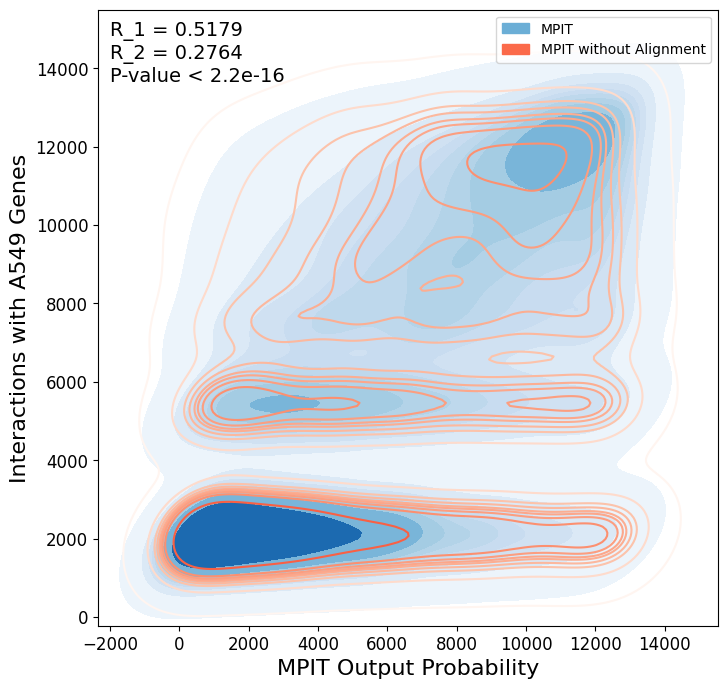

In [18]:
fig = plt.figure(figsize=(8, 8))
sns.kdeplot(x=pred_with_interactions_1.avg_score.rank(), y=pred_with_interactions_1.Cancer_Gene_Interactions.rank(), cmap='Blues',
            thresh=0.01, fill=True,)
sns.kdeplot(x=pred_with_interactions_2.avg_score.rank(), y=pred_with_interactions_2.Cancer_Gene_Interactions.rank(), cmap='Reds',
            thresh=0.01, fill=False,)

correlation_1, pvalue_1 = scipy.stats.spearmanr(pred_with_interactions_1.avg_score,
                                           pred_with_interactions_1.Cancer_Gene_Interactions
                                        )

correlation_2, pvalue_2 = scipy.stats.spearmanr(pred_with_interactions_2.avg_score,
                                           pred_with_interactions_2.Cancer_Gene_Interactions
                                        )
                                     
print(correlation_1, pvalue_1, correlation_2, pvalue_2)
plt.text(0.02, 0.98, fr'''R_1 = {correlation_1:.4f}
R_2 = {correlation_2:.4f}
P-value < {2.2e-16:.1e}''', transform=plt.gca().transAxes, fontsize=14, ha='left', va='top')
plt.xlabel('MPIT Output Probability', fontsize=16)
plt.ylabel(f'Interactions with {CELL_LINE} Genes', fontsize=16)
bmap = plt.cm.get_cmap('Blues', 5)
rmap = plt.cm.get_cmap('Reds', 5)
red_patch = mpatches.Patch(color=rmap(2), label='MPIT without Alignment')
blue_patch = mpatches.Patch(color=bmap(2), label='MPIT')
plt.legend(handles=[blue_patch, red_patch], loc='best')
plt.gca().tick_params(axis='both', labelsize=12)
fig.savefig(f'data/Results/{CELL_LINE}_correlation_cginteractions.svg')

## GO TERM Analysis

In [1]:
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt
import utils
gp.__version__

'1.0.5'

In [2]:
DATA_DIR = "data/Breast_Cancer_Matrix"
# DATA_DIR = "data/Leukemia_Matrix"
# DATA_DIR = "data/Lung_Cancer_Matrix"
CELL_LINE = utils.get_cell_line(DATA_DIR)
KCGs = pd.read_csv(f'label_collect/{CELL_LINE}/positive/NCG.txt', header=None).iloc[:, 0].values

In [3]:
enr_k = gp.enrichr(gene_list=f'label_collect/{CELL_LINE}/positive/NCG.txt', # or "./tests/data/gene_list.txt",
                 gene_sets=['GO_Biological_Process_2023','GO_Molecular_Function_2023','GO_Cellular_Component_2023'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [4]:
ax_k = gp.barplot(enr_k.results,
              column="Adjusted P-value",
              group='Gene_set', 
              title=f'Known {CELL_LINE} Genes',
              size=10,
              top_term=5,
              figsize=(3,5),
              color=['darkred', 'darkblue', 'orange'], # set colors for group
              ofname=f'data/Results/enrichr_{CELL_LINE}_k.svg'
             )

In [3]:
preds_1 = pd.read_csv(f'data/Results/{CELL_LINE}_unknown_pred.csv')
preds_1 = preds_1.sort_values(by=['avg_score'], ascending=False)
print(preds_1.head(5))
preds_1 = preds_1.gene_name.tolist()[:100]
print(preds_1)

     gene_name  score_0  score_1  score_2   score_3  score_4  avg_score   
4771     UBE2I      1.0      1.0      1.0  1.000000      1.0        1.0  \
942       CCT3      1.0      1.0      1.0  1.000000      1.0        1.0   
8642     AURKA      1.0      1.0      1.0  1.000000      1.0        1.0   
2429      RELA      1.0      1.0      1.0  1.000000      1.0        1.0   
3274      CDK4      1.0      1.0      1.0  0.999999      1.0        1.0   

      pred_label  
4771           1  
942            1  
8642           1  
2429           1  
3274           1  
['UBE2I', 'CCT3', 'AURKA', 'RELA', 'CDK4', 'LMNA', 'RAD21', 'PSMC5', 'GSK3B', 'BLM', 'GRB7', 'XPO1', 'HSP90AA1', 'CCT2', 'CSNK1G2', 'MDM4', 'CCT4', 'YY1', 'PRKDC', 'DHX9', 'LYN', 'CREB1', 'CCT6A', 'RNF2', 'CDK5', 'CCT8', 'STK4', 'SMAD1', 'NCOA2', 'KAT2B', 'ASH2L', 'BTRC', 'KAT5', 'PABPC1', 'SKP2', 'HNRNPA1', 'PTK2', 'XRCC6', 'CARM1', 'ERBB4', 'RBL1', 'CDK9', 'TFAP2C', 'YWHAZ', 'WWP1', 'UCHL5', 'UBC', 'CCT5', 'PLEC', 'SHC1', 'CEBPB'

In [10]:

enr_u = gp.enrichr(gene_list=preds_1,
                 gene_sets=['GO_Biological_Process_2023','GO_Molecular_Function_2023','GO_Cellular_Component_2023'],
                 organism='human',
                 outdir=None, # don't write to disk
                )

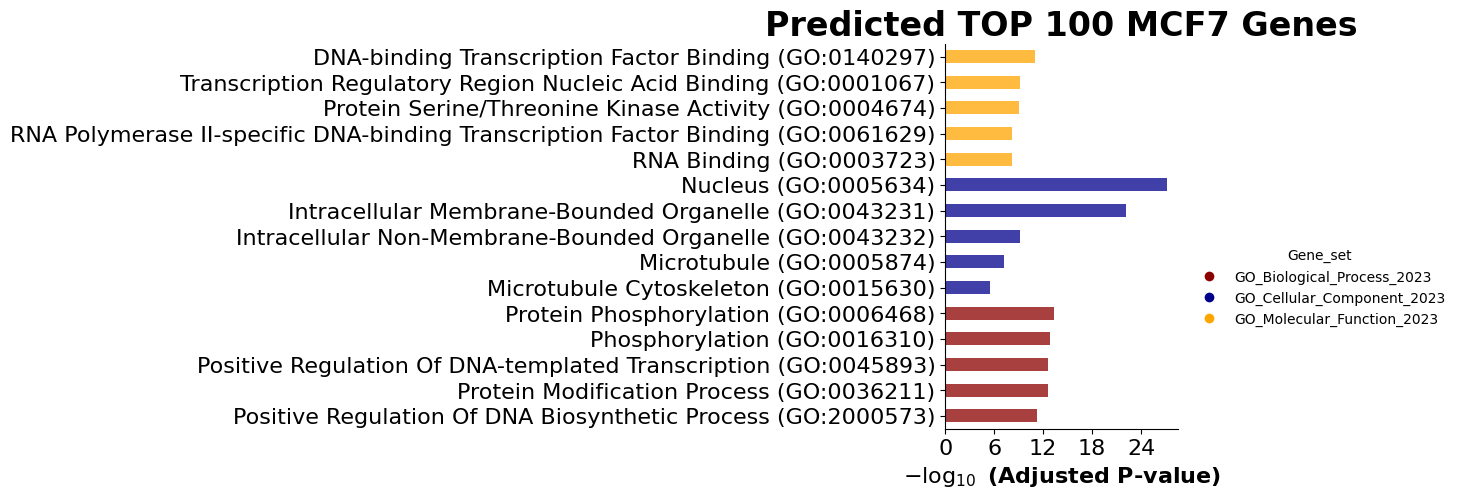

In [11]:
ax_u = gp.barplot(enr_u.results,
              column="Adjusted P-value",
              group='Gene_set',
              title=f'Predicted TOP 100 {CELL_LINE} Genes',
              size=10,
              top_term=5,
              figsize=(3,5),
              color=['darkred', 'darkblue', 'orange'], # set colors for group
              ofname=None#f'data/Results/enrichr_{CELL_LINE}_u.svg'
             )
plt.show()